In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, Sed, LightCurve, SNSurvey, SkyObject
from astropy.table import Table

import pickle

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
errf_dict = {band:np.array([]) for band in bandpasses.names}
redshifts = []
with open('plasticc_data/SNIa_SkyObjects.pkl', 'rb') as sne:
    for sn in pickle.load(sne):
        
        redshifts.append(sn.specz)
        
        pmin, pmax = -20, 80
        phase = sn.photometry['mjd'] - sn.t0
        sn.photometry = sn.photometry[(phase >= pmin) & (phase <= pmax)]
        
        ferr_cut = 0.05
        sn.photometry = sn.photometry[np.abs(sn.photometry['flux_err']/sn.photometry['flux']) <= ferr_cut]  
        
        for name in bandpasses.names: 
            idx = np.where(sn.photometry['filter'] == name)[0]
            errf = np.abs(sn.photometry['flux_err'][idx]/sn.photometry['flux'][idx])
            errf_dict[name] = np.concatenate((errf_dict[name], errf))

In [13]:
biases = np.array([0, 0, -0.01,    0,    0, 0])

In [14]:
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 11100, 10)
lc = LightCurve(time, wavelen)
lc.from_model(model)

SED = lc.sed_slice(0)
objects = []

np.random.seed(11)

redshift_sample = np.random.choice(redshifts, 2000, replace=False)

for z in redshift_sample:
    
    obj = SkyObject()
    obj.specz = z
    SED.redshift(z)
    
    obj.photometry = Table()
    obj.photometry['filter'] = bandpasses.names
    fluxes = SED.fluxes(bandpasses) * (1 + biases)
    errf = np.array([np.random.choice(dist,1)[0] for dist in errf_dict.values()])
    fluxes = np.random.normal(fluxes, errf * fluxes)
    flux_err = np.clip(errf * fluxes, 1e-6, None)
    obj.photometry['flux'] = fluxes
    obj.photometry['flux_err'] = flux_err
    
    objects.append(obj)
    
SED.redshift(0)

Now train an SED

In [15]:
sed = Sed()
sed.wavelen = np.arange(1000, 11100, 100)
sed.null()

%time h,h0,filters = sed.train(objects, bandpasses, fit_bias=True, return_model=True, verbose=True, Ncpus=8)

1
lsstu 0.004615273898451328
lsstg 0.012952114405116297
lsstr -0.026460024515071658
lssti 0.02078224294011409
lsstz 0.007970598429966993
lssty 0.00434399055123958
0.01
[ 0.          0.00016109 -0.00415715  0.          0.          0.        ]
2
lsstu 0.003784371088654983
lsstg 0.008809445938666841
lsstr -0.03456359439822732
lssti 0.0135093356920314
lsstz 0.0035886276633626158
lssty 0.0018448761866436485
0.01
[ 0.          0.         -0.00521982  0.          0.         -0.        ]
3
lsstu 0.003507905436411825
lsstg 0.007573336294942642
lsstr -0.03687027216816542
lssti 0.011499966681540215
lsstz 0.0024071084748067888
lssty 0.0011910275285891038
0.01
[ 0.          0.         -0.00551267  0.          0.         -0.        ]
3
CPU times: user 1min 12s, sys: 39.3 s, total: 1min 51s
Wall time: 54.6 s


In [17]:
biases

array([ 0.  ,  0.  , -0.01,  0.  ,  0.  ,  0.  ])

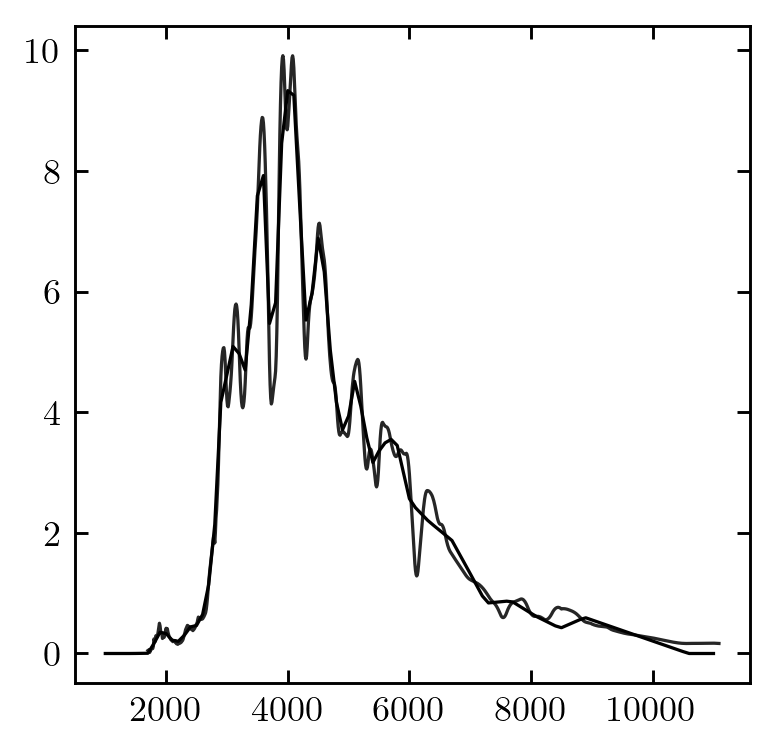

In [38]:
plt.plot(SED.wavelen, SED.flambda, c='#262626')
plt.plot(sed.wavelen, sed.flambda, ls='-', c='k')

c = ['silver','silver','C3','silver','silver','silver']
#for obj in objects:
#    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
#    plt.scatter(wavelen, obj.photometry['flux'], c=c)
    
plt.savefig('test.pdf')

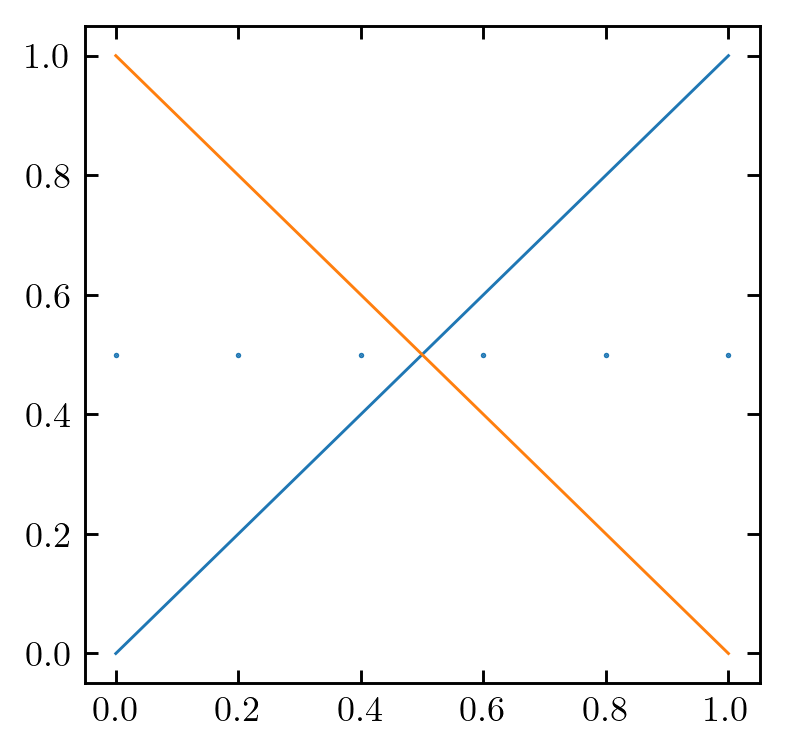

In [23]:
x = np.linspace(0,1,100)
plt.plot(x,x)
plt.plot(x,1-x)
plt.scatter([0,0.2,0.4,0.6,0.8,1],[0.5,0.5,0.5,0.5,0.5,0.5])

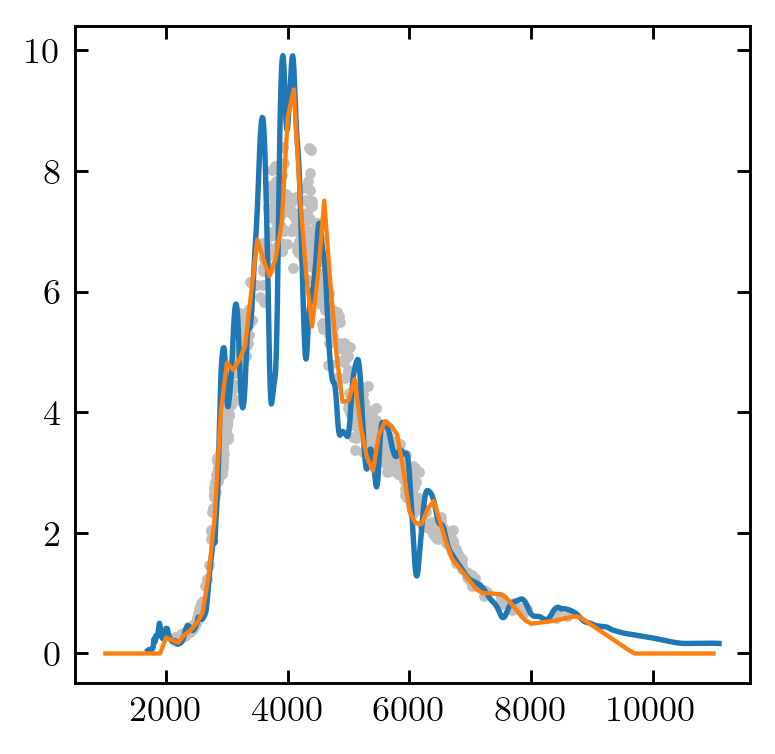

In [7]:
plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

for obj in objects:
    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
    plt.scatter(wavelen, obj.photometry['flux'], c='silver')

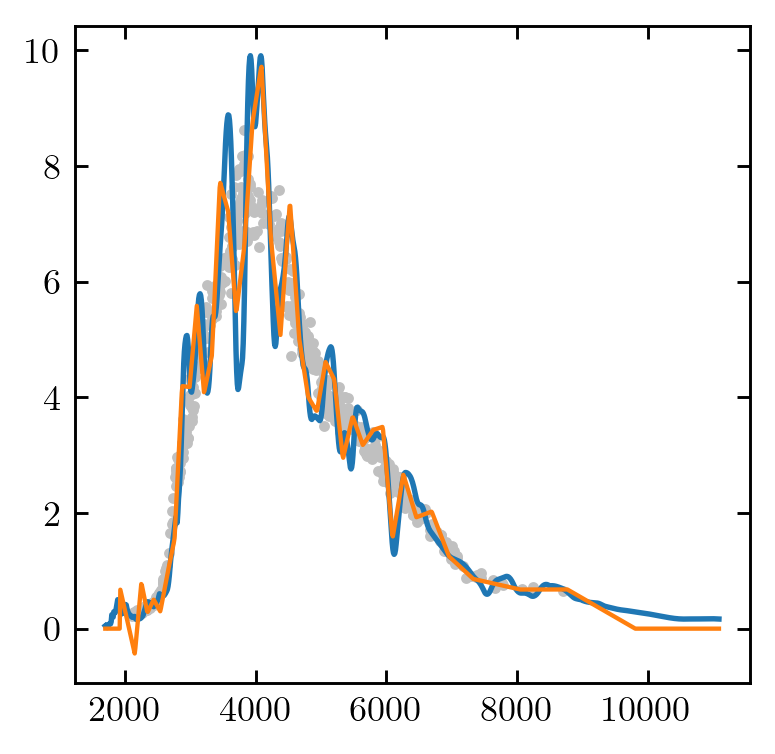

In [12]:
SED = lc.sed_slice(T)

plt.plot(SED.wavelen, SED.flambda, lw=1.5)
plt.plot(sed.wavelen, sed.flambda)

for obj in objects:
    wavelen = bandpasses.mean_wavelens(obj.photometry['filter'])/(1 + obj.specz)
    plt.scatter(wavelen, obj.photometry['flux'], c='silver')

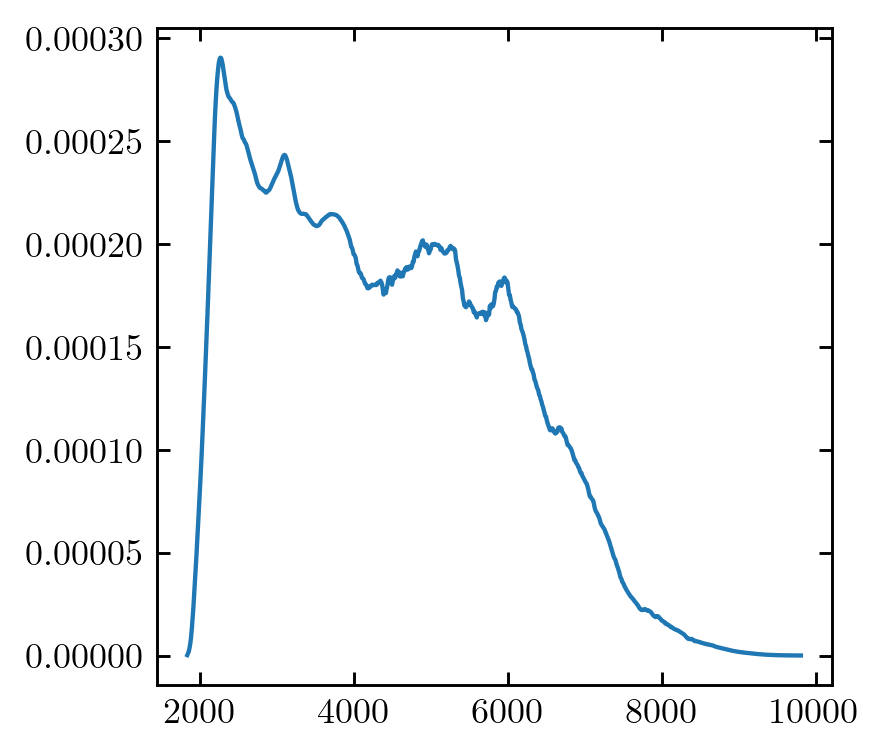

In [18]:
plt.plot(model.initbins,model.infoDen_)
plt.show()

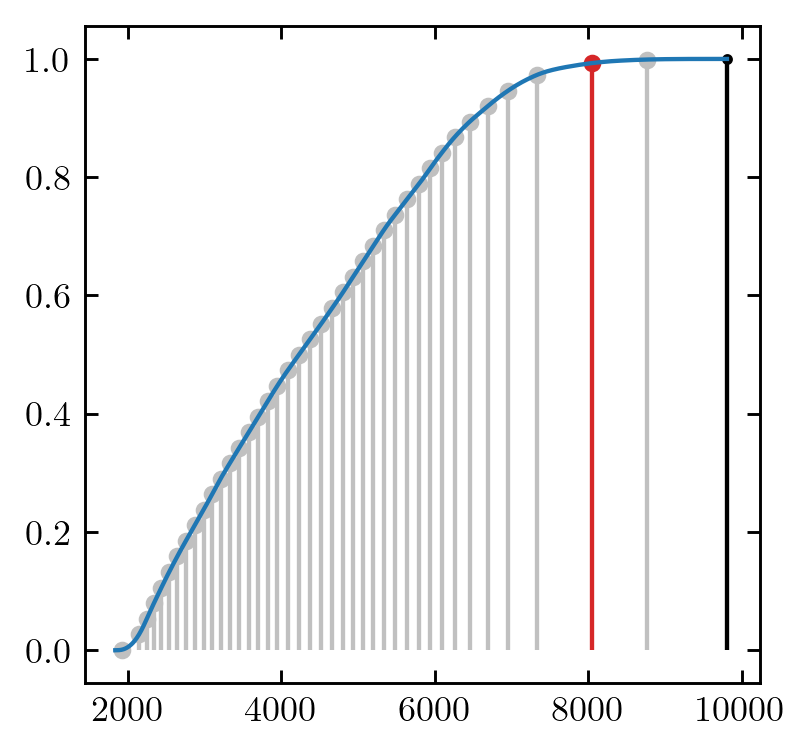

In [42]:
plt.plot(model.initbins, model.cumInfo_)
N = model.N_EDB + model.Nsplit_ - 1
for i,w in enumerate(model.allbins_):
    c = 'silver' if i < N - model.Nsplit_ or i == N else 'C3'
    
    I = np.interp(w, model.initbins, model.cumInfo_)
    plt.vlines(w, 0, I, color=c)
    plt.scatter(w, I, c=c, s=15)
    
plt.vlines(model.initbins[-1], 0, 1, color='k')
plt.scatter(model.initbins[-1], 1, c='k')

In [217]:
plt.rc('axes', prop_cycle=(cycler('color', ['#262626',"#fc8d62",'#4e79a7',"#66c2a5",'#e15759',"#8da0cb",'tab:pink','silver']) +
                           cycler('linestyle', 2*['-', '--', ':', '-.']) +
                           cycler('linewidth', 2*[1, 1.2, 1.3, 1.2])))

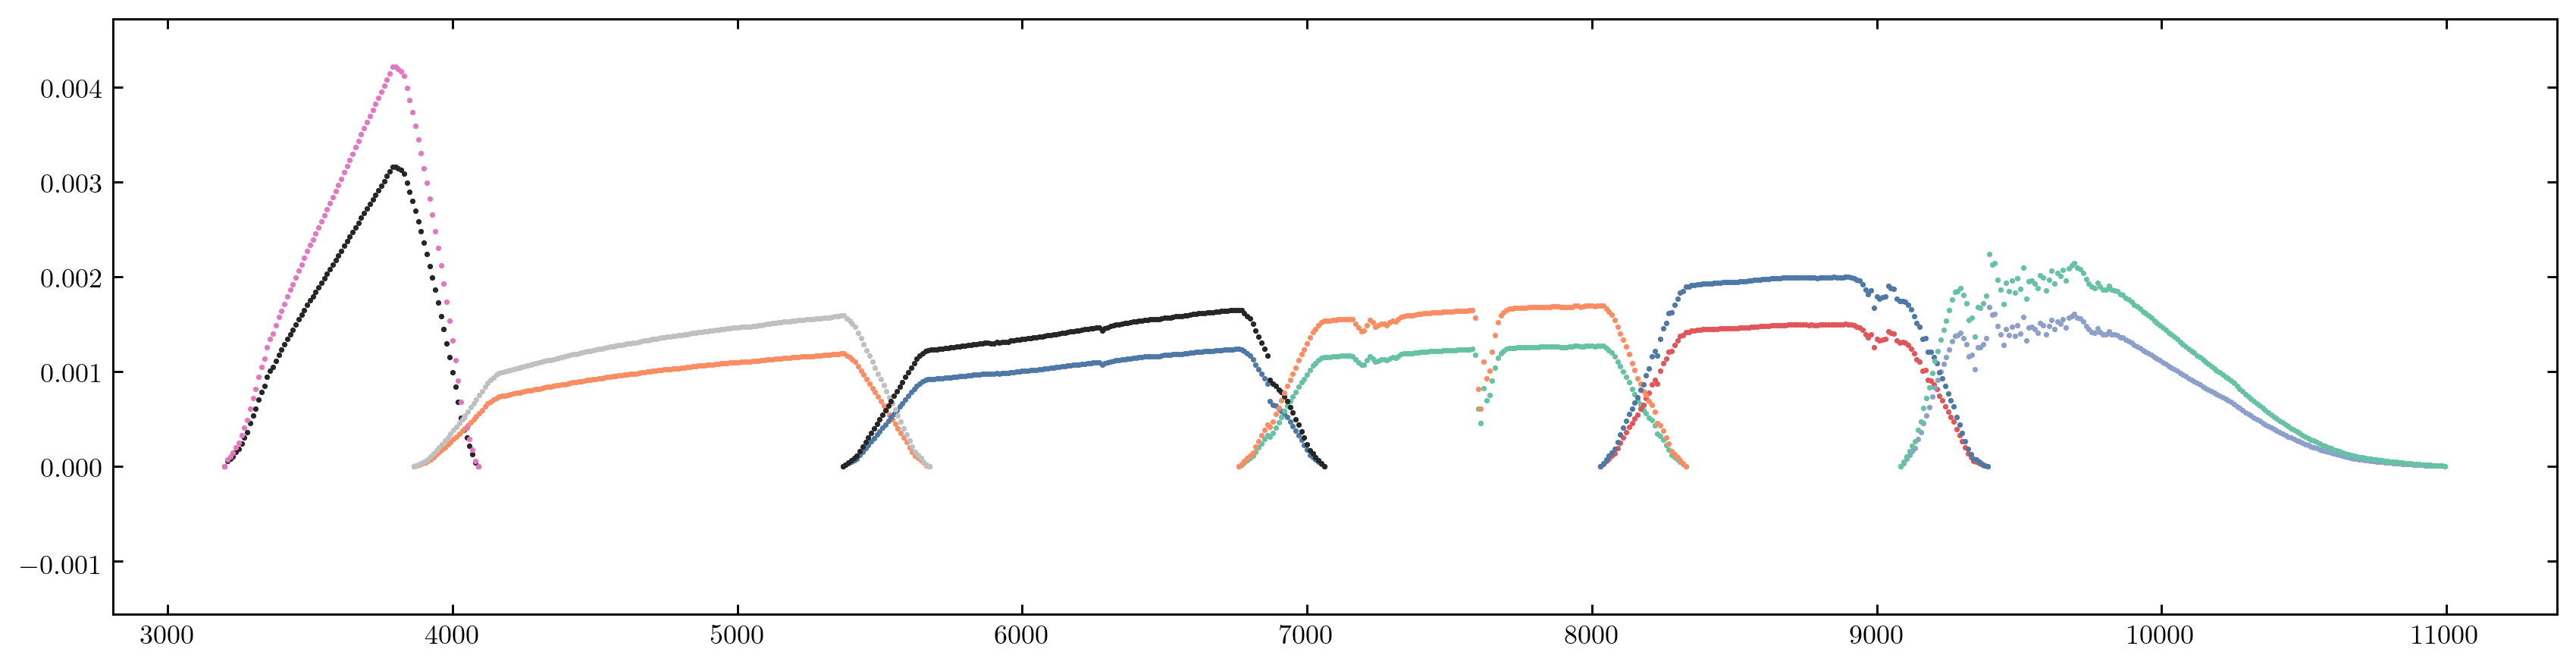

In [221]:
fig,ax = plt.subplots(figsize=(16,4))

for band in bandpasses.bands():
    plt.scatter(band.wavelen, 1.5*band.R)

i = 0
for band in bandpasses.bands():
    plt.scatter(band.wavelen, 2*band.R)
    i += 1
    if i == 20:
        break

In [52]:
from cycler import cycler

In [ ]:
- -- : -.

In [154]:
2*[2,3]

[2, 3, 2, 3]